In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.cm as cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import xml.etree.ElementTree as ET # type: ignore
from collections import defaultdict # type: ignore
import matplotlib.patheffects as path_effects # type: ignore
from matplotlib.ticker import FixedFormatter, FixedLocator # type: ignore

In [2]:
def load_node_table(file_path) :
    node_map = {}
    with open(file_path, 'r') as file :
        for line in file :
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

{0: 0, 1: 1, 2: 10, 3: 11, 4: 12, 5: 13, 6: 14, 7: 15, 8: 16, 9: 17, 10: 18, 11: 19, 12: 2, 13: 3, 14: 4, 15: 5, 16: 6, 17: 7, 18: 8, 19: 9, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 59, 58: 35, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 73, 72: 74, 73: 75, 74: 76, 75: 77, 76: 78, 77: 79, 78: 58, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 99, 98: 100, 99: 101, 100: 102, 101: 104, 102: 105, 103: 107, 104: 108, 105: 109, 106: 110, 107: 111, 108: 112, 109: 113, 110: 114, 111: 116, 112: 117, 113: 119, 114: 72, 115: 120, 116: 122, 117: 123, 118: 124, 119: 125, 120: 126, 121: 127

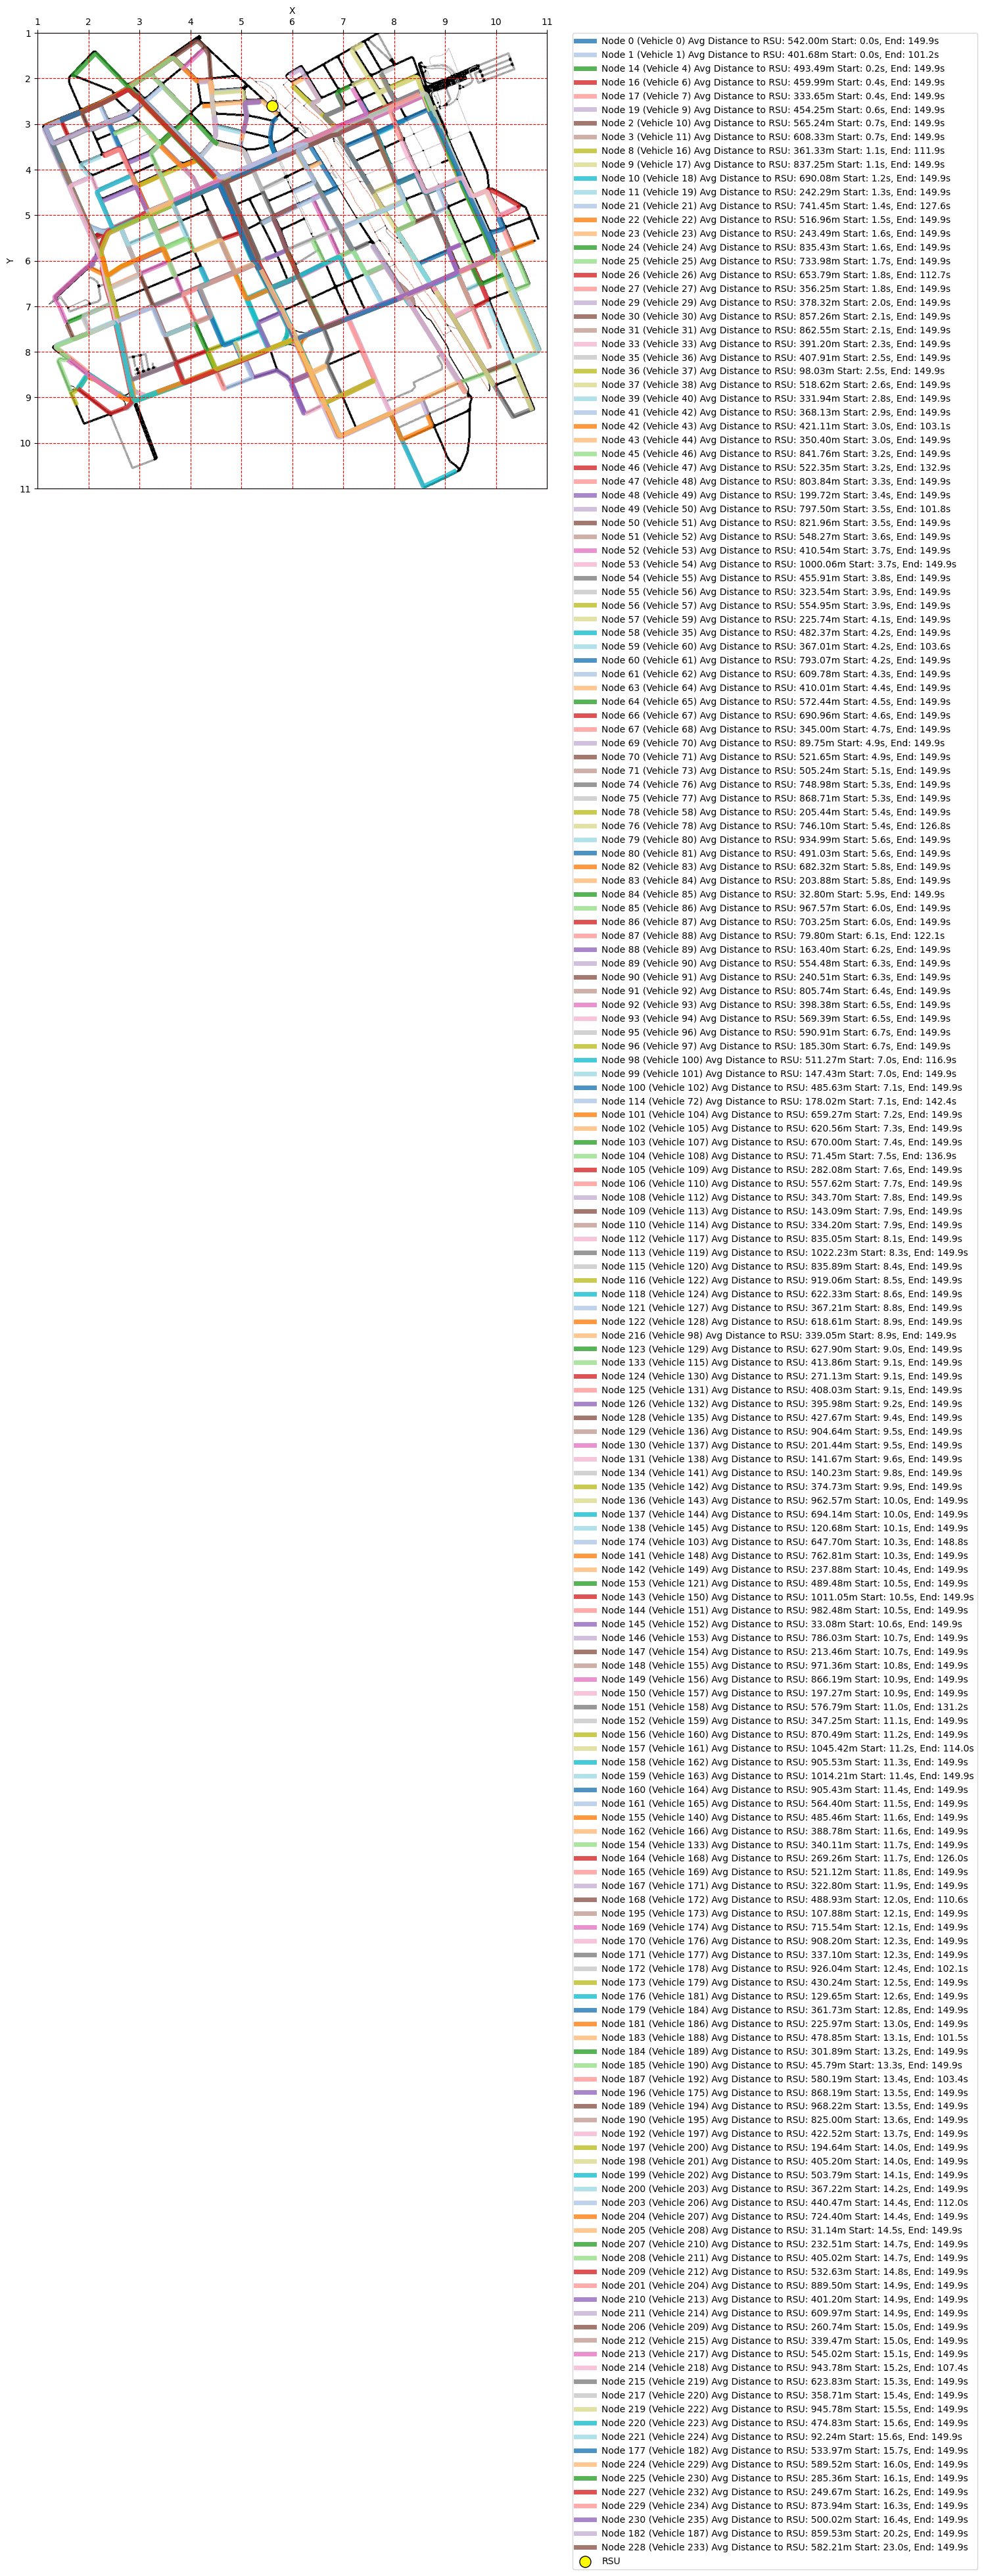

In [ ]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.cm as cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import xml.etree.ElementTree as ET # type: ignore
from collections import defaultdict # type: ignore
import matplotlib.patheffects as path_effects # type: ignore
from matplotlib.ticker import FixedFormatter, FixedLocator # type: ignore

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width = 1300, map_height = 1600, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_average_distance_to_rsu(data, rsu_x, rsu_y):
    distances = []
    for _, row in data.iterrows():
        distance = np.sqrt((row['x'] - rsu_x)**2 + (row['y'] - rsu_y)**2)
        distances.append(distance)
    return np.mean(distances)

    #plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
def plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height, grid_size=10, rsu_x=560, rsu_y=1160):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(10, 9))
    bg_img = mpimg.imread('resource/background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)
    unique_vehicle_ids = data['vehicle_id'].unique()
    #print("Vehicle IDs in Plot:", unique_vehicle_ids)

    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]

        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        avg_distance_to_rsu = calculate_average_distance_to_rsu(vehicle_data, rsu_x, rsu_y)

        
        
        if start_time < 30 and end_time >= 100:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                label=f'Node {node_id} (Vehicle {vehicle_id}) Avg Distance to RSU: {avg_distance_to_rsu:.2f}m Start: {start_time:.1f}s, End: {end_time:.1f}s', 
                zorder=1
            )
        else:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                zorder=1
            )

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()

def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def main():
    node_table = load_node_table('resource/node_table_t.txt')
    print(node_table)


    target_node_ids = [i for i in range(0, 231)]
    # 4 6 7 8 10 11 14 17 18 
    # 19 20 21 22 24 25 26
    # 19 21 
    #target_node_ids = [20, 21]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]

    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}
    print("Target Vehicle IDs:", target_vehicle_ids)
    


    dx, dy = 230, 330
    map_width=1540
    map_height=1380
    data = extract_data_from_xml('resource/map5.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    print(data['vehicle_id'].unique())
    
    plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height)

if __name__ == "__main__":
    main()

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 76, 76: 77, 77: 78, 78: 79, 79: 75, 80: 80, 81: 81, 82: 82, 83: 84, 84: 85, 85: 86, 86: 87, 87: 83, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114, 114: 115, 115: 116, 116: 117, 117: 118, 118: 119, 119: 120, 120: 121, 121: 122,

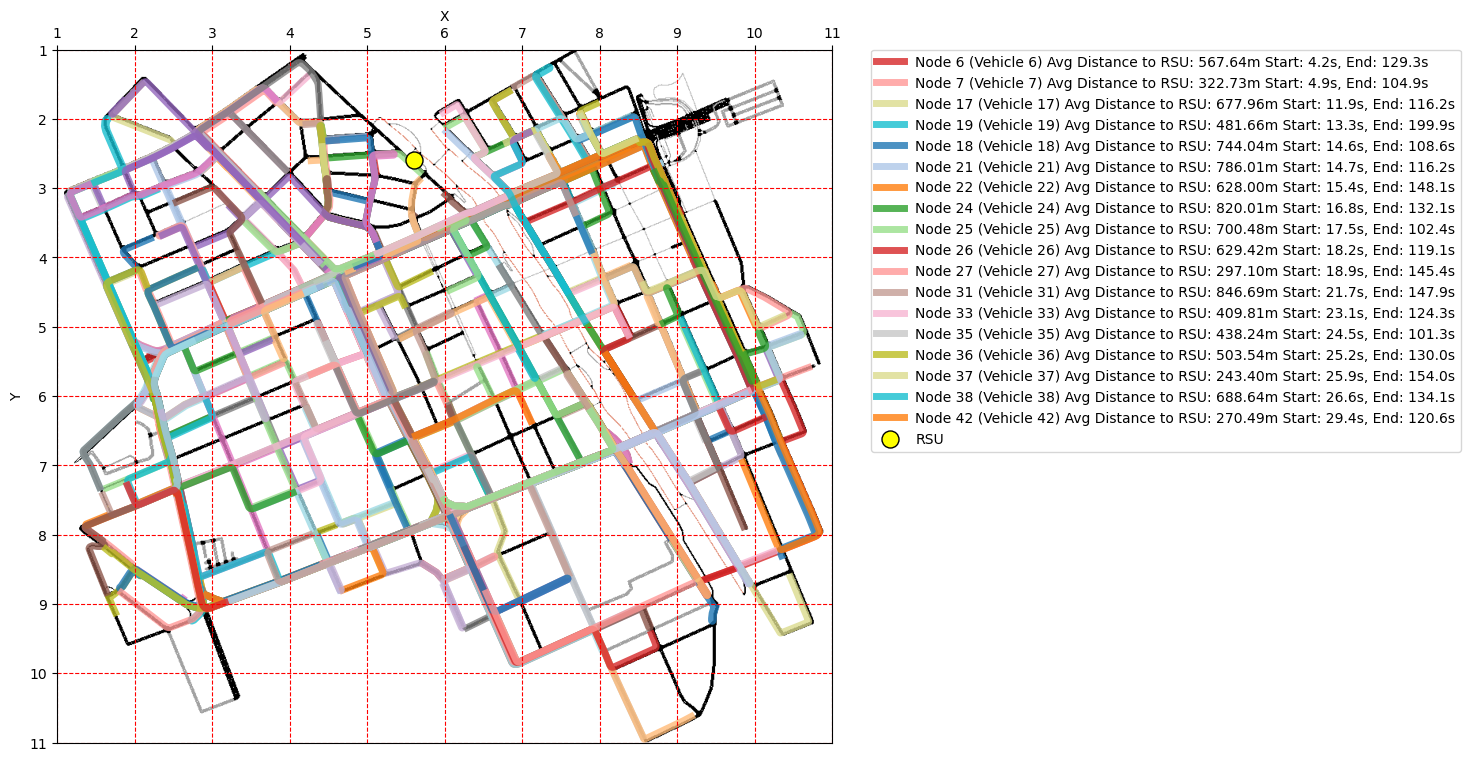

In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.cm as cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import xml.etree.ElementTree as ET # type: ignore
from collections import defaultdict # type: ignore
import matplotlib.patheffects as path_effects # type: ignore
from matplotlib.ticker import FixedFormatter, FixedLocator # type: ignore

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width = 1300, map_height = 1600, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_average_distance_to_rsu(data, rsu_x, rsu_y):
    distances = []
    for _, row in data.iterrows():
        distance = np.sqrt((row['x'] - rsu_x)**2 + (row['y'] - rsu_y)**2)
        distances.append(distance)
    return np.mean(distances)

    #plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
def plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height, grid_size=10, rsu_x=560, rsu_y=1160):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(10, 9))
    bg_img = mpimg.imread('resource/background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)
    unique_vehicle_ids = data['vehicle_id'].unique()
    #print("Vehicle IDs in Plot:", unique_vehicle_ids)


    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]

        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        avg_distance_to_rsu = calculate_average_distance_to_rsu(vehicle_data, rsu_x, rsu_y)

        
        
        if start_time < 30 and end_time >= 100:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                label=f'Node {node_id} (Vehicle {vehicle_id}) Avg Distance to RSU: {avg_distance_to_rsu:.2f}m Start: {start_time:.1f}s, End: {end_time:.1f}s', 
                zorder=1
            )
        else:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                zorder=1
            )

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()

def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def main():
    node_table = load_node_table('resource/node_table_middle.txt')
    node_table = load_node_table('resource/node_table_low.txt')
    print(node_table)


    target_node_ids = [i for i in range(0, 231)]
    # 4 6 7 8 10 11 14 17 18 
    # 19 20 21 22 24 25 26
    # 19 21 
    #target_node_ids = [20, 21]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]

    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}
    print("Target Vehicle IDs:", target_vehicle_ids)
    


    dx, dy = 230, 330
    map_width=1540
    map_height=1380
    data = extract_data_from_xml('resource/map0.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    print(data['vehicle_id'].unique())
    

    plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height)

if __name__ == "__main__":
    main()

In [3]:
def remove_duplicates_from_file(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    seen = set()
    unique_lines = []
    
    for line in lines:
        if line not in seen:
            unique_lines.append(line)
            seen.add(line)
    
    with open(output_file, 'w') as file:
        file.writelines(unique_lines)

input_file = 'resource/external_id_table_t.txt'
output_file = 'resource/node_table_t.txt'

remove_duplicates_from_file(input_file, output_file)

In [ ]:
import pandas as pd
import numpy as np

def analyze_rreq_failure_due_to_relay(data: pd.DataFrame, source_node_id: int, dest_node_id: int,
                                      node_to_vehicle_map: dict, comm_range: float = 110.0) -> pd.DataFrame:
    source_vid = node_to_vehicle_map[source_node_id]
    dest_vid = node_to_vehicle_map[dest_node_id]

    time_steps = sorted(data['time'].unique())
    failure_records = []

    for t in time_steps:
        t_data = data[data['time'] == t]
        src = t_data[t_data['vehicle_id'] == source_vid]
        dst = t_data[t_data['vehicle_id'] == dest_vid]
        others = t_data[(t_data['vehicle_id'] != source_vid) & (t_data['vehicle_id'] != dest_vid)]

        if src.empty or dst.empty:
            continue

        src_x, src_y = src.iloc[0][['x', 'y']]
        dst_x, dst_y = dst.iloc[0][['x', 'y']]

        direct_dist = np.sqrt((src_x - dst_x) ** 2 + (src_y - dst_y) ** 2)
        if direct_dist <= comm_range:
            continue

        relay_found = False
        for _, row in others.iterrows():
            relay_x, relay_y = row[['x', 'y']]
            d1 = np.sqrt((src_x - relay_x) ** 2 + (src_y - relay_y) ** 2)
            d2 = np.sqrt((relay_x - dst_x) ** 2 + (relay_y - dst_y) ** 2)
            if d1 <= comm_range and d2 <= comm_range:
                relay_found = True
                break

        if not relay_found:
            failure_records.append({
                'time': t,
                'src_node': source_node_id,
                'dst_node': dest_node_id,
                'reason': 'No relay in communication range'
            })

    return pd.DataFrame(failure_records)

def main():
    node_table = load_node_table('resource/node_table_high.txt')
    target_node_ids = list(range(231))
    node_to_vehicle_map = {nid: node_table[nid] for nid in target_node_ids if nid in node_table}
    target_vehicle_ids = list(node_to_vehicle_map.values())

    data = extract_data_from_xml('resource/map2.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)

    failure_df = analyze_rreq_failure_due_to_relay(
        data,
        source_node_id=0,
        dest_node_id=1,
        node_to_vehicle_map=node_to_vehicle_map,
        comm_range=110.0
    )
    print(failure_df)

if __name__ == "__main__":
    main()


     time  src_node  dst_node                           reason
0     0.1         0         1  No relay in communication range
1     0.2         0         1  No relay in communication range
2     0.3         0         1  No relay in communication range
3     0.4         0         1  No relay in communication range
4     0.5         0         1  No relay in communication range
..    ...       ...       ...                              ...
816  81.7         0         1  No relay in communication range
817  81.8         0         1  No relay in communication range
818  81.9         0         1  No relay in communication range
819  82.0         0         1  No relay in communication range
820  82.1         0         1  No relay in communication range

[821 rows x 4 columns]


In [6]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import networkx as nx

def extract_data_for_all_vehicles(xml_path, time_range=(30.0, 100.0)):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    extracted_data = []
    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if not (time_range[0] <= time <= time_range[1]):
            continue
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            extracted_data.append((time, vehicle_id, x, y))
    return pd.DataFrame(extracted_data, columns=['time', 'vehicle_id', 'x', 'y'])

def analyze_rsu_connectivity_to_all(df: pd.DataFrame, rsu_pos=(800.0, 600.0), comm_range=110.0):
    failure_records = []
    grouped = df.groupby('time')

    for time, group in grouped:
        vehicles = group.set_index('vehicle_id')[['x', 'y']]
        coords = vehicles.to_numpy()
        vehicle_ids = vehicles.index.to_list()

        dists = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))
        adj_matrix = (dists <= comm_range) & (dists > 0)

        rsu_idx = len(vehicle_ids)
        coords = np.vstack([coords, np.array([[rsu_pos[0], rsu_pos[1]]])])
        new_row = np.sqrt(((coords[:-1] - rsu_pos) ** 2).sum(axis=1)) <= comm_range
        adj_matrix = np.pad(adj_matrix, ((0,1),(0,1)), constant_values=False)
        adj_matrix[:-1, -1] = new_row
        adj_matrix[-1, :-1] = new_row

        G = nx.from_numpy_array(adj_matrix)

        for i, vehicle_id in enumerate(vehicle_ids):
            if not nx.has_path(G, rsu_idx, i):
                failure_records.append({
                    'time': time,
                    'vehicle_id': vehicle_id
                })

    return pd.DataFrame(failure_records)

if __name__ == "__main__":
    xml_file = "resource/map2.xml"
    df = extract_data_for_all_vehicles(xml_file, time_range=(30.0, 100.0))
    failures = analyze_rsu_connectivity_to_all(df, rsu_pos=(800.0, 600.0), comm_range=110.0)
    print(failures)


       time  vehicle_id
0      30.0         109
1      30.0         115
2      30.0         117
3      30.0         124
4      30.0         130
...     ...         ...
5215   99.8         864
5216   99.9         825
5217   99.9         864
5218  100.0         825
5219  100.0         864

[5220 rows x 2 columns]


In [48]:
import math

# 설정값
tx_power_mw = 7.5  # 송신 전력 (mW)
rx_sensitivity_dbm = -80  # 수신 감도 (dBm)
frequency_hz = 5.9e9  # 주파수 (Hz)

# mW → dBm 변환
tx_power_dbm = 10 * math.log10(tx_power_mw)

# 최대 허용 경로 손실 계산
max_path_loss_db = tx_power_dbm - rx_sensitivity_dbm

# Free Space Path Loss 공식 역산 → 거리 계산
log10_d = (max_path_loss_db + 147.55 - 20 * math.log10(frequency_hz)) / 20
distance_m = 10 ** log10_d

print(f"송신 전력: {tx_power_dbm:.2f} dBm")
print(f"최대 경로 손실: {max_path_loss_db:.2f} dB")
print(f"전송 가능 최대 거리: {distance_m:.2f} m")


송신 전력: 8.75 dBm
최대 경로 손실: 88.75 dB
전송 가능 최대 거리: 110.71 m


In [62]:
import math

# 설정값
tx_power_mw = 7.5                  # 송신 전력 (mW)
rx_sensitivity_dbm = -80           # 수신 감도 (dBm)
frequency_mhz = 5895               # 주파수 (MHz), IEEE 802.11p 채널 1 기준

# 1. mW → dBm 변환
tx_power_dbm = 10 * math.log10(tx_power_mw)

# 2. 최대 허용 경로 손실 계산
max_path_loss_db = tx_power_dbm - rx_sensitivity_dbm

# 3. FSPL 역산 → 거리 계산 (단위: MHz, m → 상수 147.55)
log10_d = (max_path_loss_db + 147.55 - 20 * math.log10(frequency_mhz)) / 20
distance_m = 10 ** log10_d

# 출력
print(f"송신 전력: {tx_power_dbm:.2f} dBm")
print(f"최대 경로 손실: {max_path_loss_db:.2f} dB")
print(f"전송 가능 최대 거리: {distance_m:.2f} m")


송신 전력: 8.75 dBm
최대 경로 손실: 88.75 dB
전송 가능 최대 거리: 110801801.68 m


c:\Conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


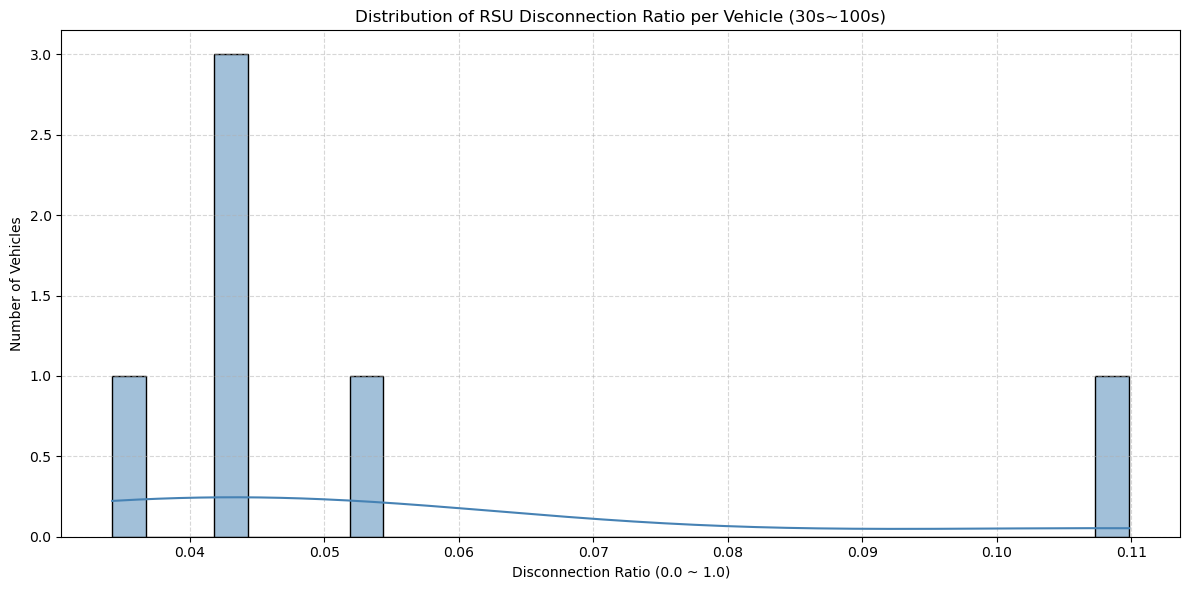

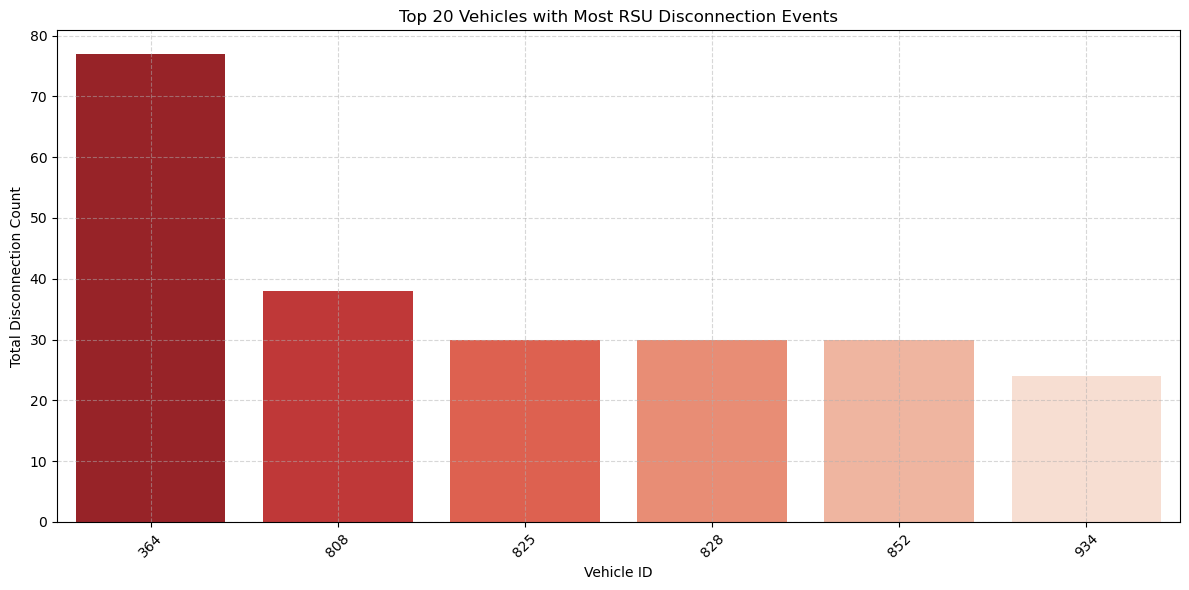

KeyError: 'vehicle_id'

In [50]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict

def extract_data_for_all_vehicles(xml_path, time_range=(30.0, 100.0)):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    extracted_data = []
    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if not (time_range[0] <= time <= time_range[1]):
            continue
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            extracted_data.append((time, vehicle_id, x, y))
    return pd.DataFrame(extracted_data, columns=['time', 'vehicle_id', 'x', 'y'])

def analyze_rsu_connectivity_per_node(df: pd.DataFrame, rsu_pos=(800.0, 600.0), comm_range=110.0):
    failure_dict = defaultdict(list)
    grouped = df.groupby('time')

    for time, group in grouped:
        vehicles = group.set_index('vehicle_id')[['x', 'y']]
        coords = vehicles.to_numpy()
        vehicle_ids = vehicles.index.to_list()

        dists = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))
        adj_matrix = (dists <= comm_range) & (dists > 0)

        rsu_idx = len(vehicle_ids)
        coords = np.vstack([coords, np.array([[rsu_pos[0], rsu_pos[1]]])])
        new_row = np.sqrt(((coords[:-1] - rsu_pos) ** 2).sum(axis=1)) <= comm_range
        adj_matrix = np.pad(adj_matrix, ((0, 1), (0, 1)), constant_values=False)
        adj_matrix[:-1, -1] = new_row
        adj_matrix[-1, :-1] = new_row

        G = nx.from_numpy_array(adj_matrix)

        for i, vehicle_id in enumerate(vehicle_ids):
            if not nx.has_path(G, rsu_idx, i):
                failure_dict[vehicle_id].append(time)

    return failure_dict

def summarize_disconnect_stats(failure_dict: dict, start_time=30.0, end_time=100.0):
    all_times = set(np.round(np.arange(start_time, end_time + 0.1, 0.1), 1))
    summary = []

    for vid, fail_times in failure_dict.items():
        fail_set = set(np.round(fail_times, 1))
        summary.append({
            'vehicle_id': vid,
            'total_disconnects': len(fail_set),
            'disconnect_ratio': len(fail_set) / len(all_times)
        })

    return pd.DataFrame(summary)

def visualize_disconnect_summary(summary_df: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    sns.histplot(summary_df['disconnect_ratio'], bins=30, kde=True, color='steelblue')
    plt.title('Distribution of RSU Disconnection Ratio per Vehicle (30s~100s)')
    plt.xlabel('Disconnection Ratio (0.0 ~ 1.0)')
    plt.ylabel('Number of Vehicles')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    top_disconnects = summary_df.sort_values('total_disconnects', ascending=False).head(20)
    sns.barplot(x='vehicle_id', y='total_disconnects', data=top_disconnects, palette='Reds_r')
    plt.title('Top 20 Vehicles with Most RSU Disconnection Events')
    plt.xlabel('Vehicle ID')
    plt.ylabel('Total Disconnection Count')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def visualize_consistently_present_disconnects(df: pd.DataFrame, failure_dict: dict, time_range=(30.0, 70.0), batch_size=10):
    start, end = time_range
    time_set = set(np.round(np.arange(start, end + 0.1, 0.1), 1))

    full_presence_vehicles = set()
    grouped = df.groupby('vehicle_id')
    required_len = len(time_set)

    for vid, group in grouped:
        times = set(np.round(group['time'].values, 1))
        if len(time_set - times) == 0:
            full_presence_vehicles.add(vid)

    filtered_summary = []
    for vid in sorted(full_presence_vehicles):
        times = failure_dict.get(vid, [])
        fail_times = set(np.round(times, 1)) & time_set
        if fail_times:
            filtered_summary.append({
                'vehicle_id': vid,
                'total_disconnects': len(fail_times),
                'disconnect_ratio': len(fail_times) / len(time_set)
            })

    df_filtered = pd.DataFrame(filtered_summary).sort_values('vehicle_id').reset_index(drop=True)
    total = len(df_filtered)

    if total == 0:
        print("30~70초 동안 내내 존재한 차량 중 RSU와 단절된 차량이 없습니다.")
        return

    num_batches = math.ceil(total / batch_size)

    for i in range(num_batches):
        batch = df_filtered.iloc[i*batch_size:(i+1)*batch_size]
        plt.figure(figsize=(10, 5))
        sns.barplot(x='vehicle_id', y='total_disconnects', data=batch, palette='crest')
        plt.title(f'RSU Disconnections (Only Fully Present Vehicles, 30s–70s)\nBatch {i+1}')
        plt.xlabel('Vehicle ID')
        plt.ylabel('Disconnection Count')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    xml_file = "resource/map2.xml"
    df = extract_data_for_all_vehicles(xml_file, time_range=(30.0, 100.0))
    failure_dict = analyze_rsu_connectivity_per_node(df, rsu_pos=(800.0, 600.0), comm_range=166.0)
    summary_df = summarize_disconnect_stats(failure_dict, start_time=30.0, end_time=100.0)
    visualize_disconnect_summary(summary_df)
    visualize_consistently_present_disconnects(df, failure_dict, time_range=(30.0, 100.0), batch_size=30)

